# Konvoluční sítě pro klasifikaci

Úkolem cvičení je upravit tento notebook a dosáhnout co nejlepšího možného validačního skóre na datasetu CIFAR-10. Viz nápovědu a možné směry úprav v komentářích u jednotlivých buněk. Klasifikaci obrázků pomocí konvolučních sítí v PyTorch popisuje notebook [pytorch-convnets](lectures/pytorch-convnets.ipynb). 

In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tqdm

import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms

import ans

## Načtení CIFAR10

In [23]:
# zlepsi predzpracovani a jine augmentace skore?
train_transform = transforms.Compose([
    transforms.ToTensor()
])

augment = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(20),
    transforms.Resize((38,38)),
    transforms.RandomCrop((32, 32)),
    transforms.ColorJitter(brightness=0.5),
    transforms.ToTensor()
])

In [24]:
train_dataset = torchvision.datasets.CIFAR10(root='..data/', train=True, download=True, transform=transforms.Compose([
    train_transform, augment])
)
train_dataset

Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               Compose(
               ToTensor()
           )
               Compose(
               ToPILImage()
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-20.0, 20.0], interpolation=nearest, expand=False, fill=0)
               Resize(size=(38, 38), interpolation=bilinear)
               RandomCrop(size=(32, 32), padding=None)
               ColorJitter(brightness=[0.5, 1.5], contrast=None, saturation=None, hue=None)
               ToTensor()
           )
           )

In [25]:
# augmentaci lze provadet i v testovacim rezimu
valid_transform = transforms.Compose([
    transforms.ToTensor()
])
augment = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ColorJitter(brightness=0.5),
    transforms.ToTensor()
])

In [26]:
valid_dataset = torchvision.datasets.CIFAR10(root='../data', train=False, download=False, transform=transforms.Compose([
    valid_transform, augment]))
valid_dataset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               Compose(
               ToTensor()
           )
               Compose(
               ToPILImage()
               RandomHorizontalFlip(p=0.5)
               ColorJitter(brightness=[0.5, 1.5], contrast=None, saturation=None, hue=None)
               ToTensor()
           )
           )

In [27]:
# pomuze jina batch_size?
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=64, shuffle=False)

## Kritérium

In [28]:
# muze zlepsit skore napr. SVM?
crit = nn.CrossEntropyLoss()
crit

CrossEntropyLoss()

## Definice konvoluční sítě

Síť definujte následující třídou `Convnet`. Není povoleno používat modely z `torchvision.models` ať už předtrénovanou či nepředtrénovanou verzi, ani jinou formu transfer learningu.

In [29]:
class Convnet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 96, 11, padding=5, stride=2, bias=False)
        self.batch1 = nn.BatchNorm2d(96)
        self.conv2 = nn.Conv2d(96, 256, 5, padding=2, bias=False)
        self.batch2 = nn.BatchNorm2d(256)
        self.conv3 = nn.Conv2d(256, 384, 3, padding=1, bias=False)
        self.batch3 = nn.BatchNorm2d(384)
        self.conv4 = nn.Conv2d(384, 256, 3, padding=1, bias=False)
        self.batch4 = nn.BatchNorm2d(256)
        self.fc1 = nn.Linear(256 * 8 * 8, 128)
        self.batch5 = nn.BatchNorm2d(1)
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        # prvni konv. vrstva
        x = self.conv1(x)
        x = F.relu(x)
        x = self.batch1(x)
        
        # druha konv. vrstva
        x = self.conv2(x)
        x = F.relu(x)
        x = self.batch2(x)
        x = F.max_pool2d(x, 2)
        
        # treti konv. vrstva
        x = self.conv3(x)
        x = F.relu(x)
        x = self.batch3(x)
        
        # ctvrta konv. vrstva
        x = self.conv4(x)
        x = F.relu(x)
        x = self.batch4(x)
        
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)
        x = F.relu(x)[None][None]
        x = self.batch5(x)
        x = x[0, 0]
        
        x = self.fc2(x)
        
        return x

## Trénování a validace

In [30]:
# pokud vytvorime novou sit, vyresetujeme i statistiky
model = Convnet()

stats = ans.Stats()

In [31]:
device = 'cuda'
model.to(device)
model.cuda()

Convnet(
  (conv1): Conv2d(3, 96, kernel_size=(11, 11), stride=(2, 2), padding=(5, 5), bias=False)
  (batch1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
  (batch2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (batch3): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (batch4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=16384, out_features=128, bias=True)
  (batch5): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [32]:
for name, par in model.named_parameters():
    print(name, par.dtype,par.device, par.shape, par.numel())

conv1.weight torch.float32 cuda:0 torch.Size([96, 3, 11, 11]) 34848
batch1.weight torch.float32 cuda:0 torch.Size([96]) 96
batch1.bias torch.float32 cuda:0 torch.Size([96]) 96
conv2.weight torch.float32 cuda:0 torch.Size([256, 96, 5, 5]) 614400
batch2.weight torch.float32 cuda:0 torch.Size([256]) 256
batch2.bias torch.float32 cuda:0 torch.Size([256]) 256
conv3.weight torch.float32 cuda:0 torch.Size([384, 256, 3, 3]) 884736
batch3.weight torch.float32 cuda:0 torch.Size([384]) 384
batch3.bias torch.float32 cuda:0 torch.Size([384]) 384
conv4.weight torch.float32 cuda:0 torch.Size([256, 384, 3, 3]) 884736
batch4.weight torch.float32 cuda:0 torch.Size([256]) 256
batch4.bias torch.float32 cuda:0 torch.Size([256]) 256
fc1.weight torch.float32 cuda:0 torch.Size([128, 16384]) 2097152
fc1.bias torch.float32 cuda:0 torch.Size([128]) 128
batch5.weight torch.float32 cuda:0 torch.Size([1]) 1
batch5.bias torch.float32 cuda:0 torch.Size([1]) 1
fc2.weight torch.float32 cuda:0 torch.Size([10, 128]) 1280

In [33]:
# s novou siti musime obnovit i seznam parametru pro optimizer
# lepsich vysledku obvykle dosahuje SGD s momentum
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), )
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9, verbose=True)
optimizer

Adjusting learning rate of group 0 to 1.0000e-03.


Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 0.001
    lr: 0.001
    weight_decay: 0
)

In [34]:
# nasledujici kod libovolne upravujte

def train_step(model, batch, crit, optimizer, stats):
    # prepnout model do trenovaciho rezimu (tyka se vrstev jako Dropout nebo BatchNorm2d)
    model.train()
    
    # zajistit, aby model i data byla na stejnem zarizeni (cpu vs gpu)
    device = next(model.parameters()).device
    inputs, targets = batch
    inputs, targets = inputs.to('cuda'), targets.to('cuda')
    
    # dopredny pruchod
    scores = model(inputs)

    # loss
    loss = crit(scores, targets)

    # pred zpetnym pruchodem vycistit prip. existujici gradienty z minulych iteraci
    optimizer.zero_grad()

    # zpetny pruchod, gradienty se ulozi primo do parametru modelu do atributu `grad`
    loss.backward()

    # update parametru na zaklade atributu `grad`
    optimizer.step()

    # vyhodnotime presnost
    _, pred = scores.max(dim=1)
    acc = torch.sum(pred == targets).float() / targets.shape[0]
    
    # update aktualnich statistik
    stats.append_batch_stats('train', loss=float(loss), acc=float(acc))

In [35]:
# jaky vliv ma pocet epoch?
# zkuste postupne menit learning rate (optimizer.param_groups[0]['lr'] = ...)
# nebo pomoci scheduleru (https://pytorch.org/docs/master/optim.html#how-to-adjust-learning-rate)

for ep in range(50):
    stats.new_epoch()
    
    # trenovaci faze
    pb = tqdm.auto.tqdm(train_loader, desc='epoch {:02d} train'.format(ep+1))
    for inputs, targets in pb:
        train_step(model, (inputs, targets), crit, optimizer, stats)
        
        pb.set_postfix(
            loss='{:.3f}'.format(stats.ravg('train', 'loss')),
            acc='{:.3f}'.format(stats.ravg('train', 'acc'))
        )
    
    # validacni faze
    scheduler.step();
    ans.validate(model, crit, valid_loader, stats)


Adjusting learning rate of group 0 to 9.0000e-04.



Adjusting learning rate of group 0 to 8.1000e-04.



Adjusting learning rate of group 0 to 7.2900e-04.



Adjusting learning rate of group 0 to 6.5610e-04.



Adjusting learning rate of group 0 to 5.9049e-04.



Adjusting learning rate of group 0 to 5.3144e-04.



Adjusting learning rate of group 0 to 4.7830e-04.



Adjusting learning rate of group 0 to 4.3047e-04.



Adjusting learning rate of group 0 to 3.8742e-04.



Adjusting learning rate of group 0 to 3.4868e-04.



Adjusting learning rate of group 0 to 3.1381e-04.



Adjusting learning rate of group 0 to 2.8243e-04.



Adjusting learning rate of group 0 to 2.5419e-04.



Adjusting learning rate of group 0 to 2.2877e-04.



Adjusting learning rate of group 0 to 2.0589e-04.



Adjusting learning rate of group 0 to 1.8530e-04.



Adjusting learning rate of group 0 to 1.6677e-04.



Adjusting learning rate of group 0 to 1.5009e-04.



Adjusting learning rate of group 0 to 1.3509e-04.



Adjusting learning rate of group 0 to 1.2158e-04.



Adjusting learning rate of group 0 to 1.0942e-04.



Adjusting learning rate of group 0 to 9.8477e-05.



Adjusting learning rate of group 0 to 8.8629e-05.



Adjusting learning rate of group 0 to 7.9766e-05.



Adjusting learning rate of group 0 to 7.1790e-05.



Adjusting learning rate of group 0 to 6.4611e-05.



Adjusting learning rate of group 0 to 5.8150e-05.



Adjusting learning rate of group 0 to 5.2335e-05.



Adjusting learning rate of group 0 to 4.7101e-05.



Adjusting learning rate of group 0 to 4.2391e-05.



Adjusting learning rate of group 0 to 3.8152e-05.



Adjusting learning rate of group 0 to 3.4337e-05.



Adjusting learning rate of group 0 to 3.0903e-05.



Adjusting learning rate of group 0 to 2.7813e-05.



Adjusting learning rate of group 0 to 2.5032e-05.



Adjusting learning rate of group 0 to 2.2528e-05.



Adjusting learning rate of group 0 to 2.0276e-05.



Adjusting learning rate of group 0 to 1.8248e-05.



Adjusting learning rate of group 0 to 1.6423e-05.



Adjusting learning rate of group 0 to 1.4781e-05.



Adjusting learning rate of group 0 to 1.3303e-05.



Adjusting learning rate of group 0 to 1.1973e-05.



Adjusting learning rate of group 0 to 1.0775e-05.



Adjusting learning rate of group 0 to 9.6977e-06.



Adjusting learning rate of group 0 to 8.7280e-06.



Adjusting learning rate of group 0 to 7.8552e-06.



Adjusting learning rate of group 0 to 7.0697e-06.



Adjusting learning rate of group 0 to 6.3627e-06.



Adjusting learning rate of group 0 to 5.7264e-06.



Adjusting learning rate of group 0 to 5.1538e-06.


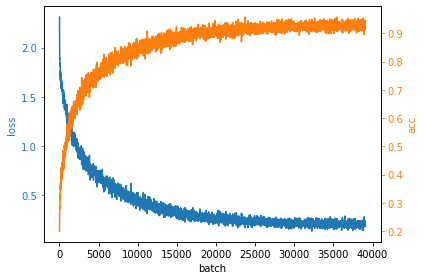

In [36]:
stats.plot_by_batch(block_len=10)

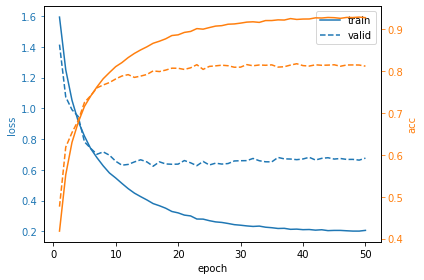

In [37]:
stats.plot_by_epoch()

In [38]:
stats.best_results()

Epoch 39,loss,acc
train,0.215243,0.923973
valid,0.666664,0.818073


## Predikce na testovacím obrázku

In [39]:
rgb_test = cv2.imread('../data/happy-green-frog.jpg')[..., ::-1]
rgb_test.dtype, rgb_test.shape, rgb_test.min(), rgb_test.max()

(dtype('uint8'), (500, 500, 3), 0, 252)

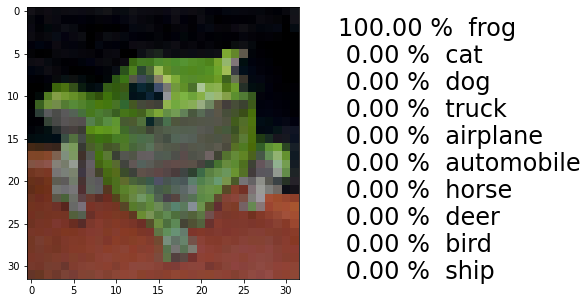

In [40]:
ans.predict_and_show(cv2.resize(rgb_test, (32, 32)), model, valid_transform, classes=train_dataset.classes)